In [1]:
import sys
import pandas as pd
import numpy as np
import pickle
sys.path.append('../')
%matplotlib inline

In [2]:
from api.utils.transformers import *
from api.utils.evaluation import evaluate_average_weekly_rank_correlation

In [3]:
from scipy.stats import spearmanr
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

### Generate Training Data

In [4]:
generator = TrainingDataGenerator('../../Welcome-Centre-DataCorps-Data/ClientDatabaseStructure.mdb.sqlite')
training_data = generator.get_training_data(limit=100000)

### Build your Transformer and Choose Features

In [5]:
features_to_split = []

transformer = TransformerPipeline([
            ConsolidateTablesTransformer(),
            AddFutureReferralTargetFeatures(),
            TimeFeatureTransformer(break_length=28),
#             SplitCurrentAndEverTransformer(['ReferralIssue_', 'ReferralDomesticCircumstances_',
#                                             'ReferralReason_', 'ReferralBenefit_'])
        ], aligner=AlignFeaturesToColumnSchemaTransformer())

X, y, referral_table = transformer.fit_transform(training_data)

X = X.fillna(0)

100%|██████████| 107/107 [00:17<00:00,  6.03it/s]


### To speed things up remove features with most columns

In [6]:
def remove_features(X, keywords_to_remove):
    features_to_remove = []
    for kw in keywords_to_remove:
        features_to_remove += list(X.filter(like=kw).columns)
    return X.drop(features_to_remove, axis=1)

In [7]:
X = remove_features(X, ['Country', 'PostCode'])

In [8]:
X_train = X[X.index < 13500]
X_test = X[X.index >= 13500]
y_train = y.loc[X_train.index]
y_test = y.loc[X_test.index]
referral_table_train = referral_table.loc[X_train.index]
referral_table_test = referral_table.loc[X_test.index]

# Build a simple regression model

In [9]:
r = Ridge()
param_grid = {'alpha':np.logspace(-3,3,num=10)}
cv = GridSearchCV(r, param_grid, cv=5, verbose=1)
cv.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   29.1s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': array([1.00000e-03, 4.64159e-03, 2.15443e-02, 1.00000e-01, 4.64159e-01,
       2.15443e+00, 1.00000e+01, 4.64159e+01, 2.15443e+02, 1.00000e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [10]:
y_pred = cv.best_estimator_.predict(X_test)
evaluate_average_weekly_rank_correlation(referral_table_test, y_test, y_pred)

/Users/davidsykes/.virtualenvs/twc/lib/python3.5/site-packages/numpy/lib/function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/davidsykes/.virtualenvs/twc/lib/python3.5/site-packages/numpy/lib/function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/davidsykes/.virtualenvs/twc/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/davidsykes/.virtualenvs/twc/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/davidsykes/.virtualenvs/twc/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


spearman    0.407292
overlap     0.352834
dtype: float64

## Build a random forest model

In [11]:
rf = RandomForestRegressor(n_estimators=100, max_features=200, max_depth=20)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features=200, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [12]:
y_pred = rf.predict(X_test)

In [13]:
evaluate_average_weekly_rank_correlation(referral_table_test, y_test, y_pred)

/Users/davidsykes/.virtualenvs/twc/lib/python3.5/site-packages/numpy/lib/function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/davidsykes/.virtualenvs/twc/lib/python3.5/site-packages/numpy/lib/function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/davidsykes/.virtualenvs/twc/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/davidsykes/.virtualenvs/twc/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/davidsykes/.virtualenvs/twc/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


spearman    0.465036
overlap     0.440711
dtype: float64

## Check where it is predicting best

,Referral_ClientId,Referral_ReferralTakenDate,y_pred,y_actual,FutureReferralTargetFeature_FutureReferralCount,referral_number,delta
15005,10,2016-10-18 11:24:00,0.066294,0.038356,2.0,6.0,1.447312
15342,10,2016-11-08 12:32:00,0.078372,0.019178,1.0,7.0,3.075332
15763,10,2016-12-02 14:09:00,0.070895,0.000000,0.0,8.0,3.686535
14097,18,2016-08-17 12:16:00,0.039928,0.057534,4.0,9.0,-1.923741
14154,18,2016-08-19 14:16:00,0.078726,0.038356,3.0,10.0,1.093738
15037,18,2016-10-19 14:20:00,0.047863,0.038356,2.0,11.0,0.488876
15351,18,2016-11-08 14:45:00,0.063393,0.019178,1.0,12.0,2.296440
15556,18,2016-11-22 14:16:00,0.057086,0.000000,0.0,13.0,2.968482
15627,23,2016-11-25 14:57:00,0.031818,0.000000,0.0,5.0,1.654543
16779,25,2017-02-06 12:39:00,0.080796,0.000000,0.0,16.0,4.201399


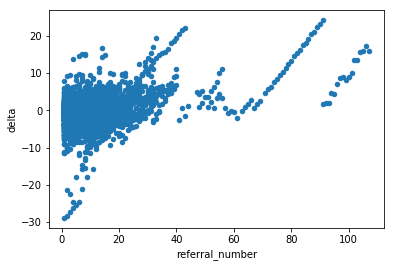

In [37]:
output = referral_table_test.copy()
output['y_pred'] = y_pred
output['pred_future_count'] = y_pred*52
output['y_actual'] = y_test
output['delta'] = output['pred_future_count'] - output['FutureReferralTargetFeature_FutureReferralCount']
output['referral_number'] = X_test['TimeFeature_ReferralNumber']
output = output[['Referral_ClientId', 'Referral_ReferralTakenDate',
                 'y_pred', 'y_actual','FutureReferralTargetFeature_FutureReferralCount',
                 'referral_number', 'delta']].sort_values(['Referral_ClientId',
                                                                        'Referral_ReferralTakenDate'])
output.plot(kind='scatter', x='referral_number', y='delta')
output

# Save your model

In [ ]:
from api.utils.models import TWCModel

In [ ]:
model = TWCModel()
model.transformer = transformer
model.model = et
model.save('etmodel.p')

In [ ]:
model2 = TWCModel()

In [ ]:
model2.load('etmodel.p')

### Test your model works on json test file

In [ ]:
with open('../api/twc_sample_request.json') as f:
    json_string = f.read()

In [ ]:
p = ParseJSONToTablesTransformer()
example_tables = p.fit_transform(json_string)

In [ ]:
model2.transformer.fit_transform(example_tables)